In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as spy
import seaborn as sns
import sklearn as skl
import xgboost as xgb

In [3]:
# Define the location of the data to be read in.
DATA_PATH = '~/Documents/DS/Data/kic/'

In [4]:
# Set data variables
training_data = pd.read_csv(DATA_PATH + 'exoTrain.csv')
testing_data = pd.read_csv(DATA_PATH + 'exoTest.csv')

In [5]:
# Seperate features (time series) from target (label)
target = 'LABEL'

In [6]:
# Define functions to do forward fourier transformation
def ft(x):
    y = spy.fft(x, n= x.size)
    return np.abs(y)
    
def spectrum_transform(X):
    X = X.copy()
    X = X.div(X.sum(axis=1), axis=0)
    X = X.apply(ft, axis=1)
    X = pd.DataFrame.from_records(X.iloc[[x for x in range(len(X))]])
    
    ### The spectra are perfectly symmetrical, so cut them in half to reduct dimensionality ###
    size = len(X.columns) - 1599
    X = X.loc[:,size:]
    # Give each column a uniform name
    # Fixes situations where imported foriegn rows have different number of BJKD
    for i in range(len(X.columns)):
        X = X.rename(columns={X.columns[i]: f'f.{i+1}'})
    return X

In [7]:
# Apply transformation to training and testing data
train = spectrum_transform(training_data.drop(columns=target))
test = spectrum_transform(testing_data.drop(columns=target))

In [8]:
# Get target vectors
y_train = training_data[target]
y_test = testing_data[target]

In [1]:
# Plot first line from training data to ensure spectrum data looks correct
plt.style.use('fivethirtyeight')

fig = plt.figure(figsize=(8,5))
plt.axes(frameon=False)
ax = plt.plot(train.iloc[0], linewidth=0.7, color='C1', alpha=0.7)
plt.title('Spectrum analysis')
plt.ylabel('Fluctuation')
plt.xlabel('Frequency')
plt.grid(False)
plt.yticks([])
plt.xticks([])

plt.show()

NameError: name 'plt' is not defined

In [10]:
# Oversample the training data
from imblearn.over_sampling import SMOTE

In [11]:
# Oversampling
sample = SMOTE(sampling_strategy='minority', random_state=42, )
train_xres, train_yres = sample.fit_resample(train, y_train)

In [12]:
train_xres = pd.DataFrame(train_xres, columns=train.columns)

In [13]:
# Attempt a standard randomforest classifier
rf_model = skl.ensemble.RandomForestClassifier(n_estimators = 100, max_depth = 7, random_state=42, n_jobs=-1)
rf_model.fit(train_xres, train_yres)
y_pred = rf_model.predict(test)
y_pred = pd.Series(y_pred)

# View Details of the results

In [14]:
y_test[y_test == 2]

0    2
1    2
2    2
3    2
4    2
Name: LABEL, dtype: int64

In [15]:
y_pred[y_pred == 2]

1      2
4      2
332    2
487    2
513    2
dtype: int64

## How did the Random Forest model do?

In [16]:
print('The precision of the Random Forest model is low, at just',(2/5)*100,'%')
print("Recall is exactly the same.")
print("False positives predicted at",(3/5)*100,'%')

The precision of the Random Forest model is low, at just 40.0 %
Recall is exactly the same.
False positives predicted at 60.0 %


In [17]:
print(skl.metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.99      0.99      0.99       565
           2       0.40      0.40      0.40         5

    accuracy                           0.99       570
   macro avg       0.70      0.70      0.70       570
weighted avg       0.99      0.99      0.99       570



# XGBClassifier

### Why I chose this model
> The XGBClassifier has a slight advantage to the random forest in this type of problem. The biggest strength to the XGBClassifier is it's ability to enhance predictions with prior knowledge. Given that strength, we're able to assist in building better trees as the model gains complexity. This allows the model to hone in on much more subtle queues and overall increases accuracy and recall. To avoid overfitting to the testing data, as this wouldn't be available if we were using this model on new data, I use early stopping to prevent the classifier from getting "too good" at predicting the right class.

In [18]:
boost_model2 = xgb.XGBClassifier(n_estimators=1000, learning_rate=0.25, max_depth=3, random_state=42, n_jobs=-1)
eval_set2 = [(train, y_train),(test, y_test)]
boost_model2.fit(train_xres, train_yres, early_stopping_rounds=25, eval_metric='aucpr', eval_set=eval_set2)

[0]	validation_0-aucpr:0.093434	validation_1-aucpr:0.038768
Multiple eval metrics have been passed: 'validation_1-aucpr' will be used for early stopping.

Will train until validation_1-aucpr hasn't improved in 25 rounds.
[1]	validation_0-aucpr:0.317825	validation_1-aucpr:0.10486
[2]	validation_0-aucpr:0.691998	validation_1-aucpr:0.252463
[3]	validation_0-aucpr:0.731783	validation_1-aucpr:0.436667
[4]	validation_0-aucpr:0.787892	validation_1-aucpr:0.441265
[5]	validation_0-aucpr:0.811447	validation_1-aucpr:0.482091
[6]	validation_0-aucpr:0.828308	validation_1-aucpr:0.469717
[7]	validation_0-aucpr:0.896721	validation_1-aucpr:0.523861
[8]	validation_0-aucpr:0.929397	validation_1-aucpr:0.492923
[9]	validation_0-aucpr:0.943433	validation_1-aucpr:0.502403
[10]	validation_0-aucpr:0.961954	validation_1-aucpr:0.476969
[11]	validation_0-aucpr:0.971942	validation_1-aucpr:0.484501
[12]	validation_0-aucpr:0.977859	validation_1-aucpr:0.462266
[13]	validation_0-aucpr:0.983276	validation_1-aucpr:0.458

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.25, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

# How to Interpret this data:

> The following code illustrates a procedure that may seem a bit unorthodox. At it's surface, this code takes the predicted probability from the model and if that values is greater than 1%, returns a positive prediction class (2). It may seem at first counter intuitive to take such small percentages to assume a positive prediction, but this is done for a couple of reasons.

> The model generally appears to be very sure, with most of the data, on if it thinks there is not a transit. Most prediction probabilities range around 95 - 99%. Because the model is generally very confident about non-transits, whenever there is a little uncertainty, that indicates that signals for transit may be present.

> Because the model is tree based, it is very hard to figure out new transit signals. On the other hand, negative transit signals are available in abundance. Therefore, the likelyhood of a false negative is extremely low. By ruling out what the model knows is negative, we can hone in on what is positive. The false positive rate will be higher, but the idea is that recall should be at or very near zero.

> It may be possible to take the positives and filter further with different transformations. This will be explored later on.

In [19]:
y_pred2 = boost_model2.predict_proba(test)

y_pred3 = []
for x, y in y_pred2:
    if y >= 0.0095:
        y_pred3.append(2)
    else:
        y_pred3.append(1)
        
print(skl.metrics.classification_report(y_test, y_pred3))

              precision    recall  f1-score   support

           1       1.00      0.89      0.94       565
           2       0.08      1.00      0.14         5

    accuracy                           0.89       570
   macro avg       0.54      0.95      0.54       570
weighted avg       0.99      0.89      0.94       570



## As expected, recall is at 1, with a very low (relative) precision.

### Here is a plot of the AUC/PR score curve

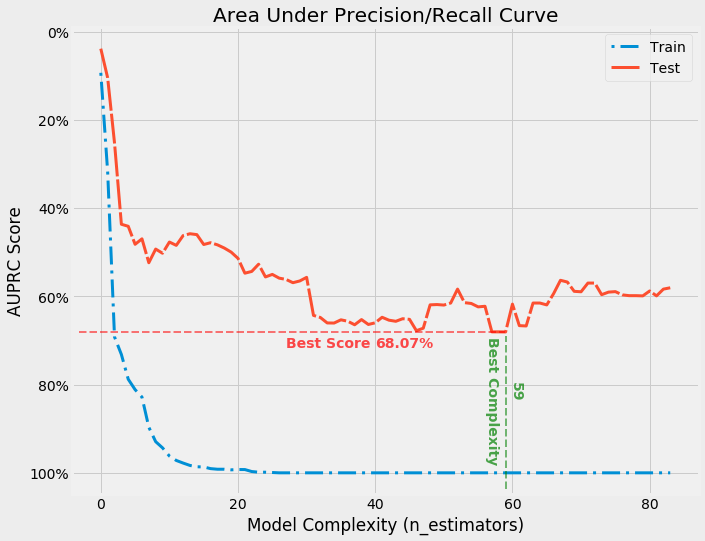

In [20]:
# Plot the model scores

# Set style and variables
plt.style.use('fivethirtyeight')
train_score = boost_model2.evals_result()['validation_0']['aucpr']
test_score = boost_model2.evals_result()['validation_1']['aucpr']
est_index = [index for index, value in enumerate(test_score) if value == max(test_score)]

# Load the figure and parameters
fig = plt.figure(figsize=(10,8), facecolor='#ededed')

# Plot the data (Also instantiates the axes)
plt.plot(train_score, color='C0', label='Train', dashes=([1,2,6,2]), linewidth=3)
plt.plot(test_score, color='C1', label='Test', dashes=([10,1]), linewidth=3)

# Draw lines for best model and best complexity intersection
plt.axhline(max(test_score), 0.01, 0.69, color='red', linewidth=1.5, dashes=(5,2), alpha=.7)
plt.axvline(est_index, 0.01, 0.339, color='green', linewidth=1.5, dashes=(5,2), alpha=.7)

# Write texts and title
plt.text(27, 0.715, s="Best Score", color='Red', alpha=.7, fontweight='bold')
plt.text(56, 0.975, s='Best Complexity', rotation=-90, color='green', alpha=.7, fontweight='bold')
plt.text(40, 0.715, s='{:.2f}%'.format(max(test_score)*100), color='red', alpha=.7, fontweight='bold')
plt.text(59.5, 0.83, s=est_index[0], rotation=-90, color='green', alpha=.7, fontweight='bold')
plt.title('Area Under Precision/Recall Curve')

# Fix the y axis 
plt.ylabel('AUPRC Score')
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1], labels=['0%', '20%', '40%', '60%', '80%', '100%'])
plt.gca().invert_yaxis()

# Fix the x axis
plt.xlabel('Model Complexity (n_estimators)')

# Sub params and show
plt.legend()
plt.show()

In [21]:
# I have to do this crazy calculations because python thinks 112 / 565 is 22.4. Not even close.
cm1 = skl.metrics.confusion_matrix(y_test, y_pred3)
row0 = cm1[[0]].sum()
row1 = cm1[[1]].sum()

cm_final = np.array(
    [[cm1[0,0]/row0*100,
      cm1[0,1]/row0*100],
     [cm1[1,0]/row1*100,
      cm1[1,1]/row1*100]]
)
print(cm_final)

[[ 89.38053097  10.61946903]
 [  0.         100.        ]]


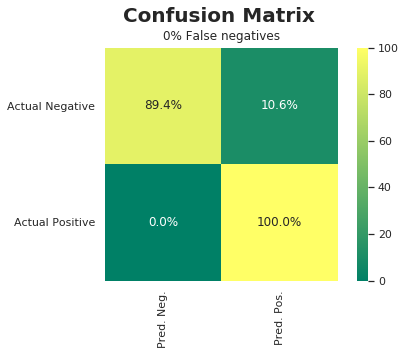

In [22]:
sns.set()

fig, ax0 = plt.subplots(1,1)
plt.suptitle('Confusion Matrix', fontsize=20, y=1.02, fontweight='bold')
plt.title('0% False negatives', y=1.005)
ax = sns.heatmap(cm_final, annot=True, fmt='.1f', square=True, cmap='summer')

# matplotlib <=> seaborn fixes
plt.yticks([1.5, 0.5], labels=['Actual Positive', 'Actual Negative'], rotation=0)
plt.xticks([0.5, 1.5], labels=['Pred. Neg.', 'Pred. Pos.'], rotation=90)
plt.gca().set_ylim(2, 0)

# fix % to annotations
for t in ax.texts: t.set_text(t.get_text() + '%')
plt.show()

# Feature Importance

### Interpretation:
> The model was able to reduce the signal information from the frequency transformation to find the frequencies that most likely indicated a transit. This was done by oversampling the confirmed positive transit signals. The model does not get a very good accuracy score due to it's inclusive nature, but without a robust sample of positive transit signals, the only way to prevent missing good candidates (and further increasing the eventual sample of positive signals) is to include as many samples as is even remotely plausible.

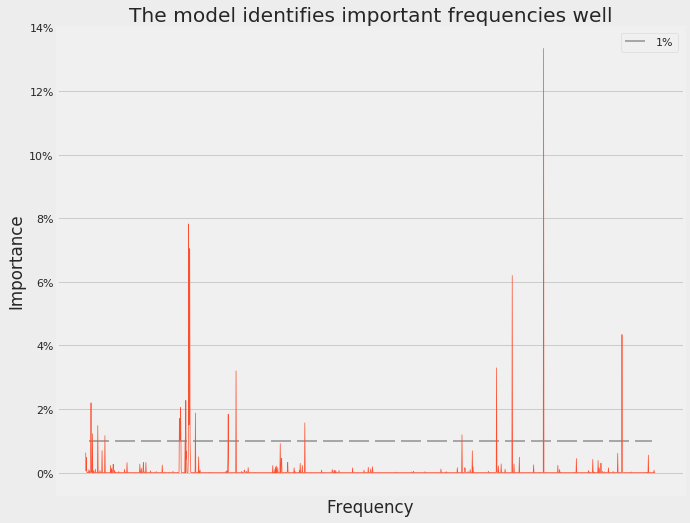



1575 frequencies were considered with less than 1% importance by the model.
24 frequencies were considered with greater than 1% importance by the model.




In [23]:
# Get feature importance
importances = boost_model2.feature_importances_

# How many were very low? High?
low = [x for x in importances if x < 0.01]
not_low = [x for x in importances if x > 0.01]

bottom = len(low)
top = len(not_low)

# Visualize the importance by frequency of signal
plt.style.use('fivethirtyeight')

# Set figure / title / axis labels
plt.figure(figsize=(10,8), facecolor='#ededed')
plt.title('The model identifies important frequencies well')
plt.ylabel('Importance')
plt.xlabel('Frequency')

# Plot a line indicating 1% (key)
plt.axhline(
    0.01, # y-axis location
    0.05, # Percent starting point (x-axis)
    0.95, # Percent ending point (x-axis)
    color='black',
    linewidth=2,
    alpha=0.3,
    dashes=(10,3),
    label='1%'
)

# Plot the feature importance
plt.plot(
    importances,
    linewidth=0.7,
    color='C1'
)

# Fix y-ticks
plt.yticks([0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14],
          labels=['0%', '2%', '4%', '6%', '8%', '10%', '12%', '14%'])
# Fix x-ticks
plt.xticks([])
# Fix x-axis
plt.gca().invert_xaxis()

# Set legend / show graph
plt.legend()
plt.show()

print('\n')
print(f'{len(low)} frequencies were considered with less than 1% importance by the model.')
print(f'{len(not_low)} frequencies were considered with greater than 1% importance by the model.')
print('\n')

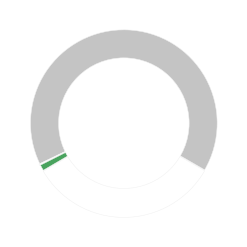

In [24]:
# Pie chart
#labels = ['All other features', 'Over 1%', '']
sizes = [bottom, 1599/250, top, 1599/2]
#colors
colors = ['#c4c4c4','white','#49a35e','white']
#explosion
explode = (0.0, 0.01, 0.0, 0.01)
 
fig1, ax1 = plt.subplots(facecolor='white')

plt.pie(
    sizes,
    colors = colors,
    startangle=-30,
    pctdistance=0.5,
    explode = explode
)

#draw circle
center_circle = plt.Circle(
    (0,0),
    0.70,
    fc='white'
)

fig = plt.gcf()
fig.gca().add_artist(center_circle)

plt.show()

# New prediction!
> Now, this file was imported from Campaign 4 of the K2 mission. It had a different number of observations (3140 instead of 3197) so let's see how our model does!

In [25]:
# This function works better, so it will replace the old transformation function
def transform_new(X):
    X = X.copy()
    
    # Normalize the new data
    mean = X.sum(axis=1) / len(X.columns)
    X = X.subtract(mean, axis=0)
    X = pd.DataFrame(skl.preprocessing.normalize(X))
    
    # Apply the FFT
    X = X.apply(ft, axis=1)
    
    # Re-format and split to correct length
    X = pd.DataFrame.from_records(X.iloc[[x for x in range(len(X))]])
    size = len(X.columns) - 1599
    X = X.loc[:,size:]
    
    # Provide uniform names for the column heads
    for i in range(len(X.columns)):
        X = X.rename(columns={X.columns[i]: f'f.{i+1}'})
        
    return X

# Get file
a882 = pd.read_csv(DATA_PATH + 'predict_this.csv')
a883 = transform_new(a882.drop(columns='LABEL'))
prediction = boost_model2.predict_proba(a883)



In [27]:
if prediction[0,1] < 0.01:
    print('No Transit')
else:
    print('Good signal for transit!')

Good signal for transit!


# Success!
> Because the positive class prediction is 2.36%, the model would return positive for the prediction in accordance with our class weighting. There are confirmed transits in this data, so the model was successful!